# Market Making with Alpha - Order Book Imbalance

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-06-05-41e7931982274a24a48eb545222cf531">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
from numba import njit
import pandas as pd
import numpy as np

from numba.typed import Dict

from hftbacktest import (
    NONE,
    BUY,
    SELL,
    GTX,
    HftBacktest,
    SquareProbQueueModel,
    Linear,
    Stat,
    IntpOrderLatency,
    PartialFillExchange
)

@njit(cache=True)
def obi_mm(
    hbt,
    stat,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
):
    imbalance_timeseries = np.full(30_000_000, np.nan, np.float64)

    t = 0
    
    grid_num = 1
    grid_interval = hbt.tick_size
    window = window / interval
    
    while hbt.elapse(interval):
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        
        sum_ask_qty = 0.0
        upto_tick = min(int(np.floor(mid_price * (1 + depth) / hbt.tick_size)), hbt.high_ask_tick + 1)
        for tick_price in range(hbt.best_ask_tick, upto_tick):
            sum_ask_qty += hbt.ask_depth.get(tick_price, 0)
                
        sum_bid_qty = 0.0
        upto_tick = max(int(np.ceil(mid_price * (1 - depth) / hbt.tick_size)), hbt.low_bid_tick - 1)
        for tick_price in range(hbt.best_bid_tick, upto_tick, -1):
            sum_bid_qty += hbt.bid_depth.get(tick_price, 0)
                
        imbalance_timeseries[t] = sum_bid_qty - sum_ask_qty
        
        # Standardizes the order book imbalance timeseries for a given window
        m = np.nanmean(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        s = np.nanstd(imbalance_timeseries[max(0, t + 1 - window):t + 1]) 
        alpha = np.divide(imbalance_timeseries[t] - m, s)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        order_qty = max(round((order_qty_dollar / mid_price) / hbt.lot_size) * hbt.lot_size, hbt.lot_size)
        fair = mid_price + c1 * alpha
        normalized_position = hbt.position / order_qty
        bid_price = fair - half_spread - skew * normalized_position
        ask_price = fair + half_spread - skew * normalized_position
        
        bid_price = np.floor(bid_price / hbt.tick_size) * hbt.tick_size
        ask_price = np.ceil(ask_price / hbt.tick_size) * hbt.tick_size
        
        bid_price = np.minimum(bid_price, hbt.best_bid)
        ask_price = np.maximum(ask_price, hbt.best_ask)

        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(imbalance_timeseries):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [2]:
latency_data = np.concatenate(
    [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230501, 20230532)]
)

Load data/btcusdt_20230501.npz
Load data/btcusdt_20230502.npz
Load data/btcusdt_20230503.npz
Load data/btcusdt_20230504.npz
Load data/btcusdt_20230505.npz
Load data/btcusdt_20230506.npz
Load data/btcusdt_20230507.npz
Load data/btcusdt_20230508.npz
Load data/btcusdt_20230509.npz
Load data/btcusdt_20230510.npz
Load data/btcusdt_20230511.npz
Load data/btcusdt_20230512.npz
Load data/btcusdt_20230513.npz
Load data/btcusdt_20230514.npz
Load data/btcusdt_20230515.npz
Load data/btcusdt_20230516.npz
Load data/btcusdt_20230517.npz
Load data/btcusdt_20230518.npz
Load data/btcusdt_20230519.npz
Load data/btcusdt_20230520.npz
Load data/btcusdt_20230521.npz
Load data/btcusdt_20230522.npz
Load data/btcusdt_20230523.npz
Load data/btcusdt_20230524.npz
Load data/btcusdt_20230525.npz
Load data/btcusdt_20230526.npz
Load data/btcusdt_20230527.npz
Load data/btcusdt_20230528.npz
Load data/btcusdt_20230529.npz
Load data/btcusdt_20230530.npz
Load data/btcusdt_20230531.npz
=========== Summary ===========
Sharpe 

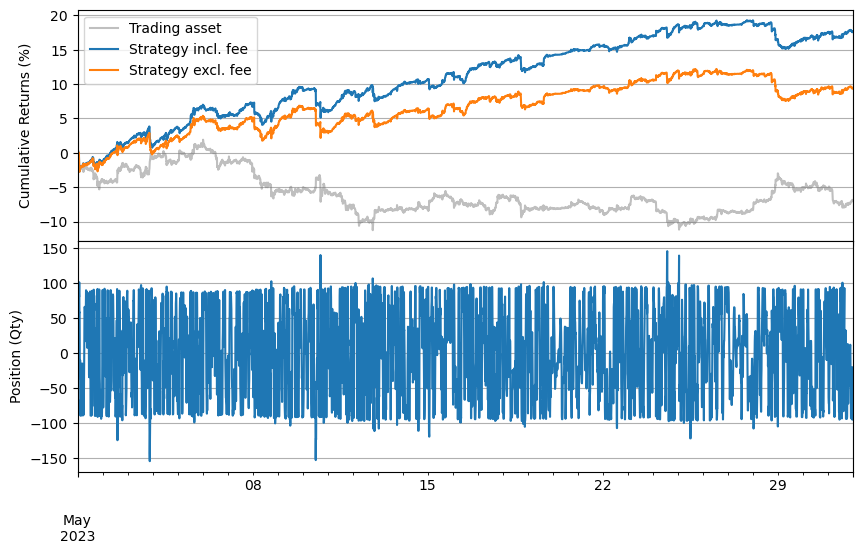

In [3]:
%%time
hbt = HftBacktest(
    [
        'data/btcusdt_{}.npz'.format(date) for date in range(20230501, 20230532)
    ],
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=IntpOrderLatency(data=latency_data),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='data/btcusdt_20230430_eod.npz'
)

stat = Stat(hbt)

half_spread = 80
skew = 3.5
c1 = 160
depth = 0.025 # 2.5% from the mid price
interval = 1_000_000 # 1s
window = 3_600_000_000 # 1hour
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 50
grid_num = 1
grid_interval = hbt.tick_size

obi_mm(
    hbt,
    stat.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
)

stat.summary(capital=max_position_dollar, resample='10min')

Load data/ethusdt_20230501.npz
Load data/ethusdt_20230502.npz
Load data/ethusdt_20230503.npz
Load data/ethusdt_20230504.npz
Load data/ethusdt_20230505.npz
Load data/ethusdt_20230506.npz
Load data/ethusdt_20230507.npz
Load data/ethusdt_20230508.npz
Load data/ethusdt_20230509.npz
Load data/ethusdt_20230510.npz
Load data/ethusdt_20230511.npz
Load data/ethusdt_20230512.npz
Load data/ethusdt_20230513.npz
Load data/ethusdt_20230514.npz
Load data/ethusdt_20230515.npz
Load data/ethusdt_20230516.npz
Load data/ethusdt_20230517.npz
Load data/ethusdt_20230518.npz
Load data/ethusdt_20230519.npz
Load data/ethusdt_20230520.npz
Load data/ethusdt_20230521.npz
Load data/ethusdt_20230522.npz
Load data/ethusdt_20230523.npz
Load data/ethusdt_20230524.npz
Load data/ethusdt_20230525.npz
Load data/ethusdt_20230526.npz
Load data/ethusdt_20230527.npz
Load data/ethusdt_20230528.npz
Load data/ethusdt_20230529.npz
Load data/ethusdt_20230530.npz
Load data/ethusdt_20230531.npz
=========== Summary ===========
Sharpe 

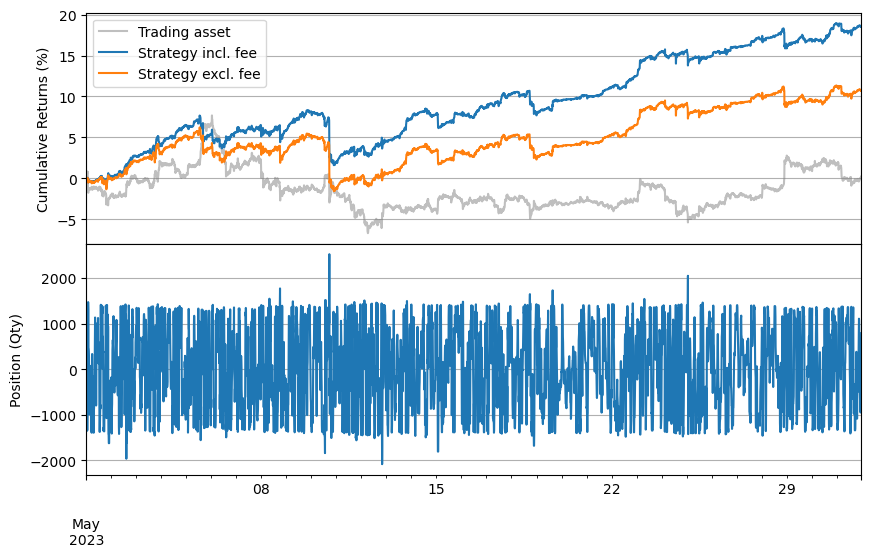

In [4]:
%%time
hbt = HftBacktest(
    [
        'data/ethusdt_{}.npz'.format(date) for date in range(20230501, 20230532)
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=IntpOrderLatency(data=latency_data),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='data/ethusdt_20230430_eod.npz'
)

stat = Stat(hbt)

half_spread = 5
skew = 0.2
c1 = 10
depth = 0.025 # 2.5% from the mid price
interval = 1_000_000 # 1s
window = 3_600_000_000 # 1hour
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 50
grid_num = 1
grid_interval = hbt.tick_size

obi_mm(
    hbt,
    stat.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
)

stat.summary(capital=max_position_dollar, resample='10min')